In [61]:
import numpy as np
import pandas as pd

In [62]:
df = pd.read_csv('spam.csv')
df.sample(5)

,Category,Message
5495,ham,"Good afternoon, my love ... How goes your day ..."
36,ham,"Oops, I'll let you know when my roommate's done"
5142,ham,Now that you have started dont stop. Just pray...
5340,ham,Are u awake? Is there snow there?
996,ham,Change again... It's e one next to escalator...


In [63]:
df.shape

(5572, 2)

Data Cleaning

In [64]:
# renaming the cols
df.rename(columns={'Category':'target','Message':'text'},inplace=True)
df.sample(5)

,target,text
297,ham,Unless it's a situation where YOU GO GURL woul...
3869,ham,"not that I know of, most people up here are st..."
1584,ham,"It's cool, let me know before it kicks off aro..."
1555,ham,Yeah we do totes. When u wanna?
2362,ham,Hi. I'm sorry i missed your call. Can you pls ...


In [65]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

In [66]:
df['target'] = encoder.fit_transform(df['target'])
df.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [67]:
# missing values
df.isnull().sum()

target    0
text      0
dtype: int64

In [68]:
# remove duplicates
df = df.drop_duplicates(keep='first')

In [69]:
df.duplicated().sum()

0

EDA

In [70]:
df['target'].value_counts()

target
0    4516
1     641
Name: count, dtype: int64

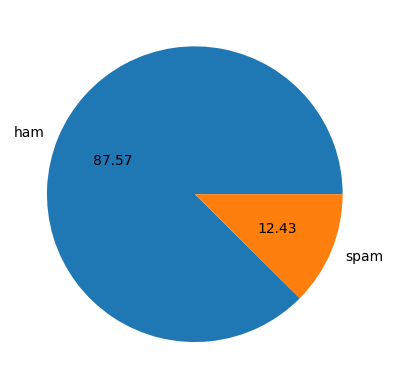

In [71]:
import matplotlib.pyplot as plt
plt.pie(df['target'].value_counts(), labels=['ham','spam'],autopct="%0.2f")
plt.show()

In [72]:
import nltk
from nltk.corpus import stopwords

In [73]:
import string

In [74]:
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

In [75]:
import seaborn as sns

In [76]:
def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    
    y=[]
    for i in text:
        if i.isalnum():
            y.append(i)
            
    text = y[:]
    y.clear()
    
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
    
    text = y[:]
    y.clear()
    
    for i in text:
        y.append(ps.stem(i))
    
            
    return " ".join(y)

In [77]:
transform_text('I Loved the YT lectures on Machine Learning. How about You?')

'love yt lectur machin learn'

In [78]:
df['transformed_text'] = df['text'].apply(transform_text)
df.head()

,target,text,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah think goe usf live around though


In [79]:
from wordcloud import WordCloud
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')

In [80]:
spam_wc = wc.generate(df[df['target'] == 1]['transformed_text'].str.cat(sep=" "))

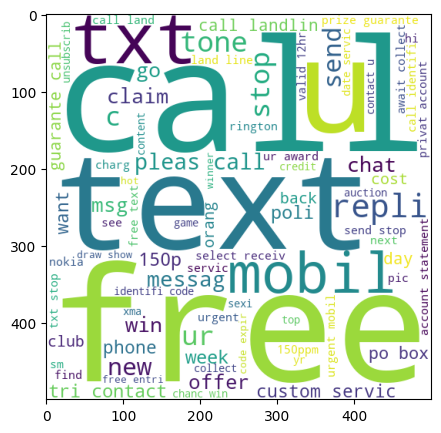

In [81]:
plt.figure(figsize=(12,5))
plt.imshow(spam_wc)

In [82]:
ham_wc = wc.generate(df[df['target'] == 0]['transformed_text'].str.cat(sep=" "))

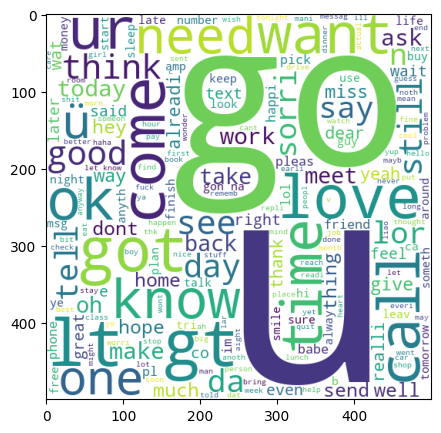

In [83]:
plt.figure(figsize=(12,5))
plt.imshow(ham_wc)

In [84]:
spam_corpus = []
for msg in df[df['target'] == 1]['transformed_text'].tolist():
    for word in msg.split():
        spam_corpus.append(word)

In [85]:
len(spam_corpus)

9781

In [86]:
from collections import Counter
Counter(spam_corpus).most_common(10)

[('call', 311),
 ('free', 186),
 ('2', 154),
 ('txt', 139),
 ('text', 122),
 ('ur', 119),
 ('u', 115),
 ('mobil', 110),
 ('stop', 108),
 ('repli', 103)]

In [87]:
ham_corpus = []
for msg in df[df['target'] == 0]['transformed_text'].tolist():
    for word in msg.split():
        ham_corpus.append(word)

In [88]:
len(ham_corpus)

35940

In [89]:
Counter(ham_corpus).most_common(10)

[('u', 897),
 ('go', 407),
 ('get', 351),
 ('2', 288),
 ('gt', 288),
 ('lt', 287),
 ('come', 278),
 ('got', 239),
 ('know', 237),
 ('like', 236)]

Model Building
countvectorizer -- bag of words

In [90]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
cv = CountVectorizer()
tfidf = TfidfVectorizer(max_features=3000)

In [91]:
X = cv.fit_transform(df['transformed_text']).toarray()
X1 = tfidf.fit_transform(df['transformed_text']).toarray()

In [92]:
y = df['target'].values

In [93]:
y

array([0, 0, 1, ..., 0, 0, 0])

In [94]:
from sklearn.model_selection import train_test_split

In [95]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)
X1_train,X1_test,y1_train,y1_test = train_test_split(X1,y,test_size=0.2,random_state=2)

In [96]:
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score,recall_score,f1_score

In [97]:
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

In [98]:
# by CountVectorizer
gnb.fit(X_train,y_train)
y_pred1 = gnb.predict(X_test)
print(accuracy_score(y_test,y_pred1))
print(precision_score(y_test,y_pred1))

0.8691860465116279
0.4826086956521739


In [99]:
mnb.fit(X_train,y_train)
y_pred2 = mnb.predict(X_test)
print(accuracy_score(y_test,y_pred2))
print(precision_score(y_test,y_pred2))

0.9796511627906976
0.9206349206349206


In [100]:
bnb.fit(X_train,y_train)
y_pred3 = bnb.predict(X_test)
print(accuracy_score(y_test,y_pred3))
print(precision_score(y_test,y_pred3))

0.9718992248062015
0.9711538461538461


In [101]:
# by TfidfVectorizer
gnb.fit(X1_train,y1_train)
y_pred1 = gnb.predict(X1_test)
print(accuracy_score(y1_test,y_pred1))
print(precision_score(y1_test,y_pred1))

0.8672480620155039
0.4782608695652174


In [102]:
mnb.fit(X1_train,y1_train)
y_pred2 = mnb.predict(X1_test)
print(accuracy_score(y1_test,y_pred2))
print(precision_score(y1_test,y_pred2))

0.9709302325581395
1.0


In [103]:
bnb.fit(X1_train,y1_train)
y_pred2 = bnb.predict(X1_test)
print(accuracy_score(y1_test,y_pred2))
print(precision_score(y1_test,y_pred2))

0.9835271317829457
0.9824561403508771


tfidf >>> cv --better results
try other classifiers

In [104]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [105]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
dtc = DecisionTreeClassifier(max_depth=5)

In [106]:
clfs = {
    'SVC' : svc,
    'KN' : knc, 
    'NB': mnb, 
    'DT': dtc
}

In [107]:
def train_classifier(clf,X1_train,y1_train,X1_test,y1_test):
    clf.fit(X1_train,y1_train)
    y_pred = clf.predict(X1_test)
    accuracy = accuracy_score(y1_test,y_pred)
    precision = precision_score(y1_test,y_pred)
    
    return accuracy,precision

In [108]:
accuracy_scores = []
precision_scores = []

for name,clf in clfs.items():
    
    current_accuracy,current_precision = train_classifier(clf, X1_train,y1_train,X1_test,y1_test)
    
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)

In [109]:
performance_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy':accuracy_scores,'Precision':precision_scores})

In [110]:
performance_df

,Algorithm,Accuracy,Precision
0,SVC,0.975775,0.981132
1,KN,0.912791,1.000000
2,NB,0.970930,1.000000
3,DT,0.936047,0.821053


In [111]:
import pickle
pickle.dump(tfidf,open('vectorizer1.pkl','wb'))
pickle.dump(mnb,open('model1.pkl','wb'))